# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the data

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight') 

In [2]:
conda install quandl

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


### Data set description:
### The U.S. Treasury ensures the nation's financial security, manages the nation's debt, collects tax revenues, and issues currency, provides data on yield rates. The Long-Term Real Rate Average is the unweighted average of bid real yields on all outstanding TIPS with remaing maturities of more than 10 years and is intended as a proxy for long-term real rates

In [3]:
quandl.ApiConfig.api_key = 'HizRzx-D6C3V4B2_wzmy'
df = quandl.get('USTREASURY/REALLONGTERM')

In [4]:
df.shape

(5968, 1)

In [5]:
df.head()

,LT Real Average (>10Yrs)
Date,
2000-01-03,4.30
2000-01-04,4.30
2000-01-05,4.30
2000-01-06,4.32
2000-01-07,4.32


In [6]:
df.columns

Index(['LT Real Average (>10Yrs)'], dtype='object')

In [7]:
type(df)

pandas.core.frame.DataFrame

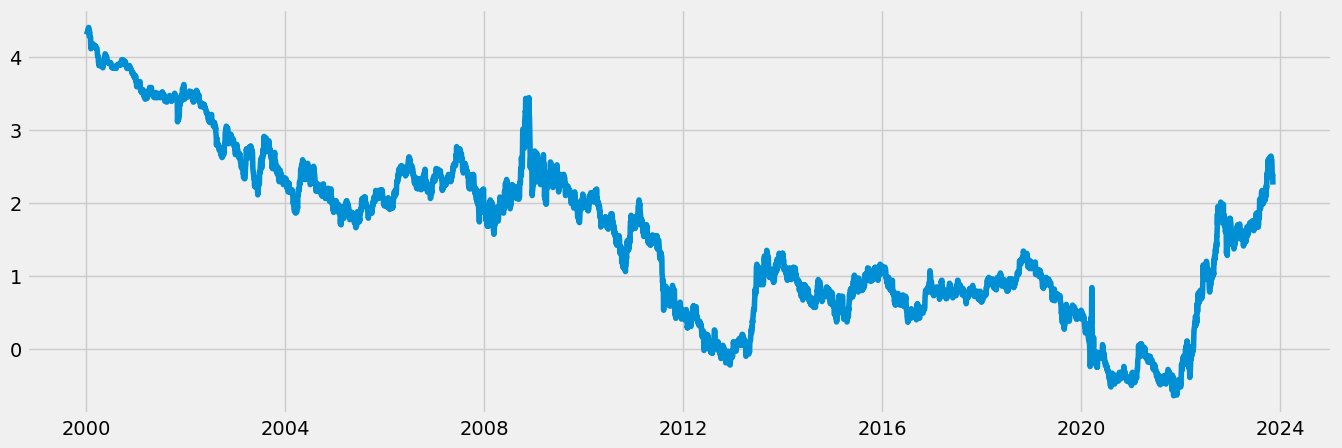

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(df)

### 2. Subsetting, wrangling, and cleaning time-series data

In [9]:
data_2 = df.reset_index()

In [10]:
data_2.head()

,Date,LT Real Average (>10Yrs)
0,2000-01-03,4.30
1,2000-01-04,4.30
2,2000-01-05,4.30
3,2000-01-06,4.32
4,2000-01-07,4.32


In [22]:
data_sub = data_2.loc[(data_2['Date'] >= '2013-01-01') & (data_2['Date'] < '2023-01-01')]

In [23]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date'])
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True) 
data_sub.head()

,LT Real Average (>10Yrs)
datetime,
2013-01-02,0.01
2013-01-03,0.10
2013-01-04,0.08
2013-01-07,0.04
2013-01-08,0.02


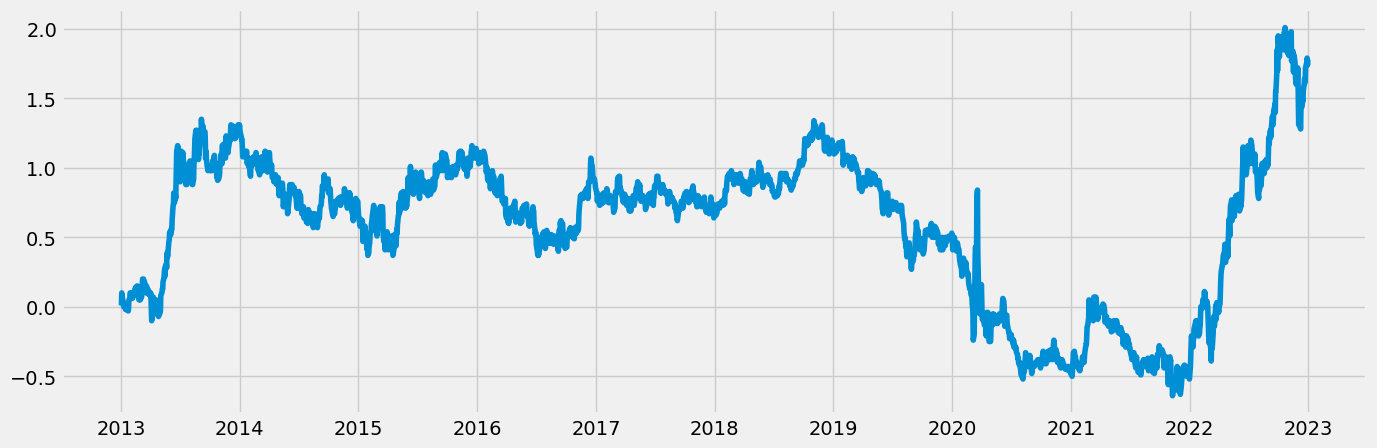

In [24]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data_sub)

In [25]:
# Check for missing values (you shouldn't have any)
data_sub.isnull().sum() 

LT Real Average (>10Yrs)    0
dtype: int64

### 3. Time-series analysis: decomposition

In [42]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive', period = 365)

In [35]:
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

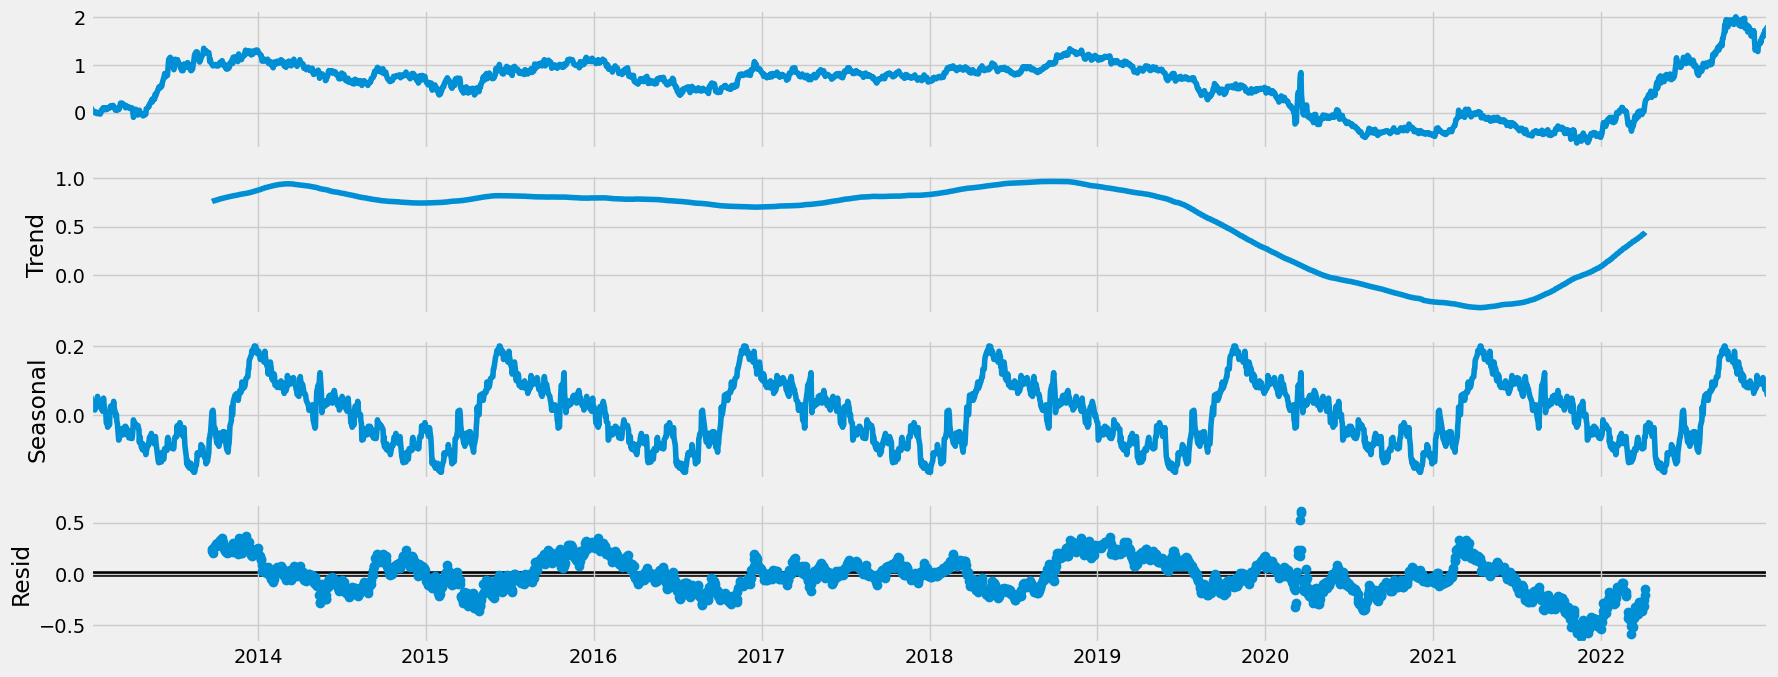

In [43]:
# Plot the separate components
decomposition.plot()
plt.show()

### From these graphs we can see rates fluctuate quite a lot. For the recent years we can see the decrease of rates after 2020, but increasing again after 2022. But even before the covid we see the inconsistence in rates

### 4. Testing for stationarity

In [45]:
# Conducting a Dickey-Fuller test to check for stationarity

from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['LT Real Average (>10Yrs)'])

Dickey-Fuller Stationarity test:
Test Statistic                   -1.219289
p-value                           0.665243
Number of Lags Used               7.000000
Number of Observations Used    2493.000000
Critical Value (1%)              -3.432976
Critical Value (5%)              -2.862700
Critical Value (10%)             -2.567388
dtype: float64


###  Critical Value (10%) has a value of -2.567388. This is much smaller than the test statistic, which is -1.219289, which means that we can’t reject the null hypothesis. A p-value is not significant. The time-series in non-stationary.

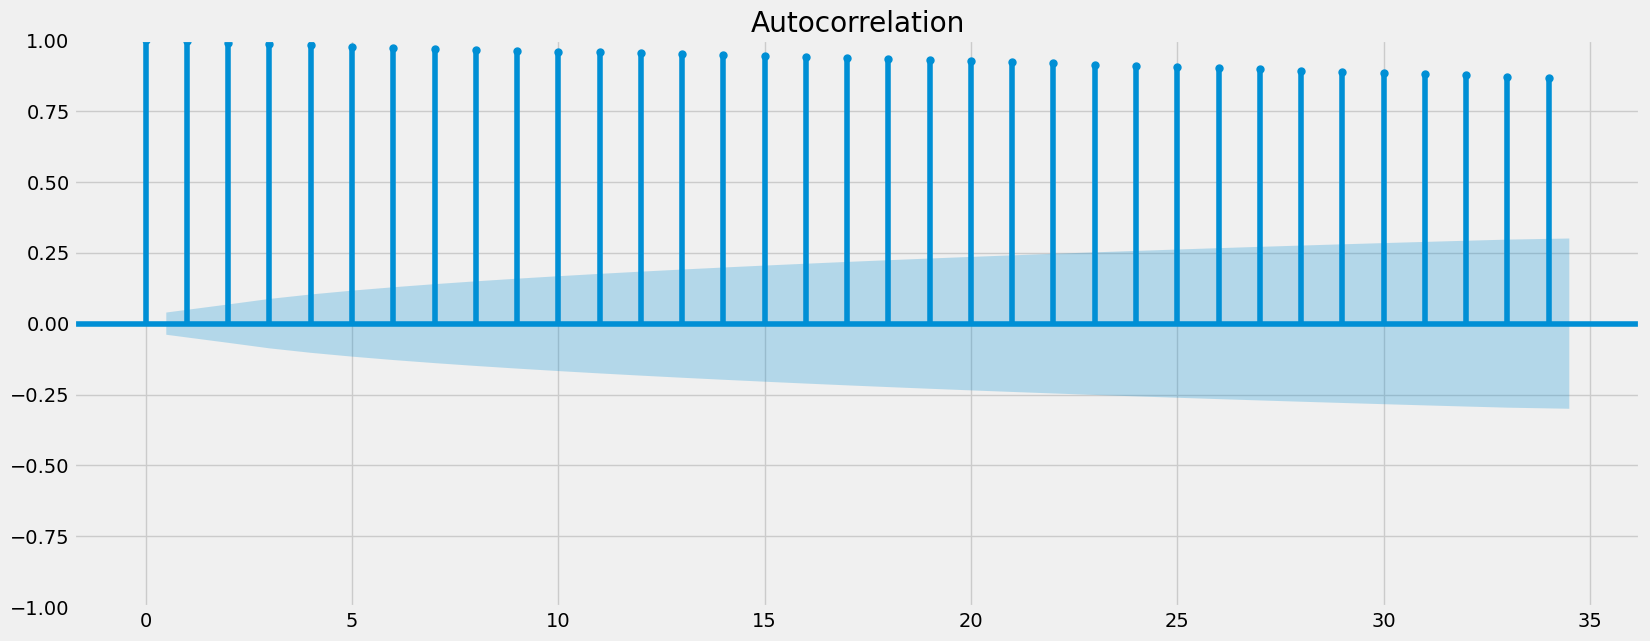

In [46]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_sub)
plt.show()

### When lines go above the blue edge of the confidence interval, this means you have lags that are significantly correlated with each other. And when you have many lags beyond this interval, you can deduce that your data is non-stationary. 

### 5. Stationarizing the US Treasury Data

In [47]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
data_diff = data_sub - data_sub.shift(1) 

In [48]:
# Remove the missing values that came about as a result of the differencing. 
data_diff.dropna(inplace = True) 

In [49]:
data_diff.head()

,LT Real Average (>10Yrs)
datetime,
2013-01-03,0.09
2013-01-04,-0.02
2013-01-07,-0.04
2013-01-08,-0.02
2013-01-09,-0.02


In [50]:
data_diff.columns

Index(['LT Real Average (>10Yrs)'], dtype='object')

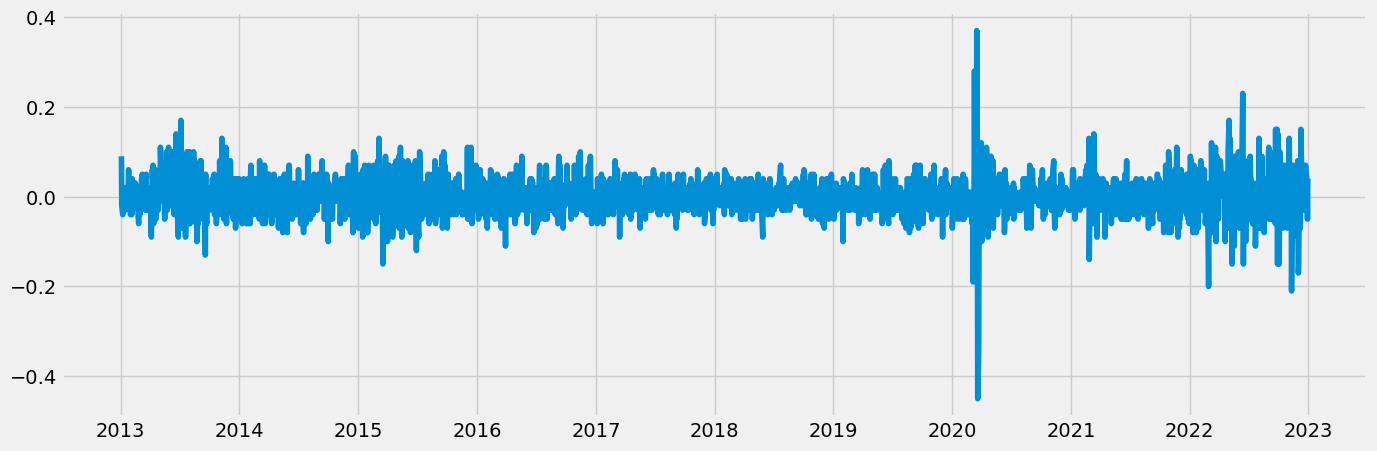

In [51]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [52]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -21.724382
p-value                           0.000000
Number of Lags Used               6.000000
Number of Observations Used    2493.000000
Critical Value (1%)              -3.432976
Critical Value (5%)              -2.862700
Critical Value (10%)             -2.567388
dtype: float64


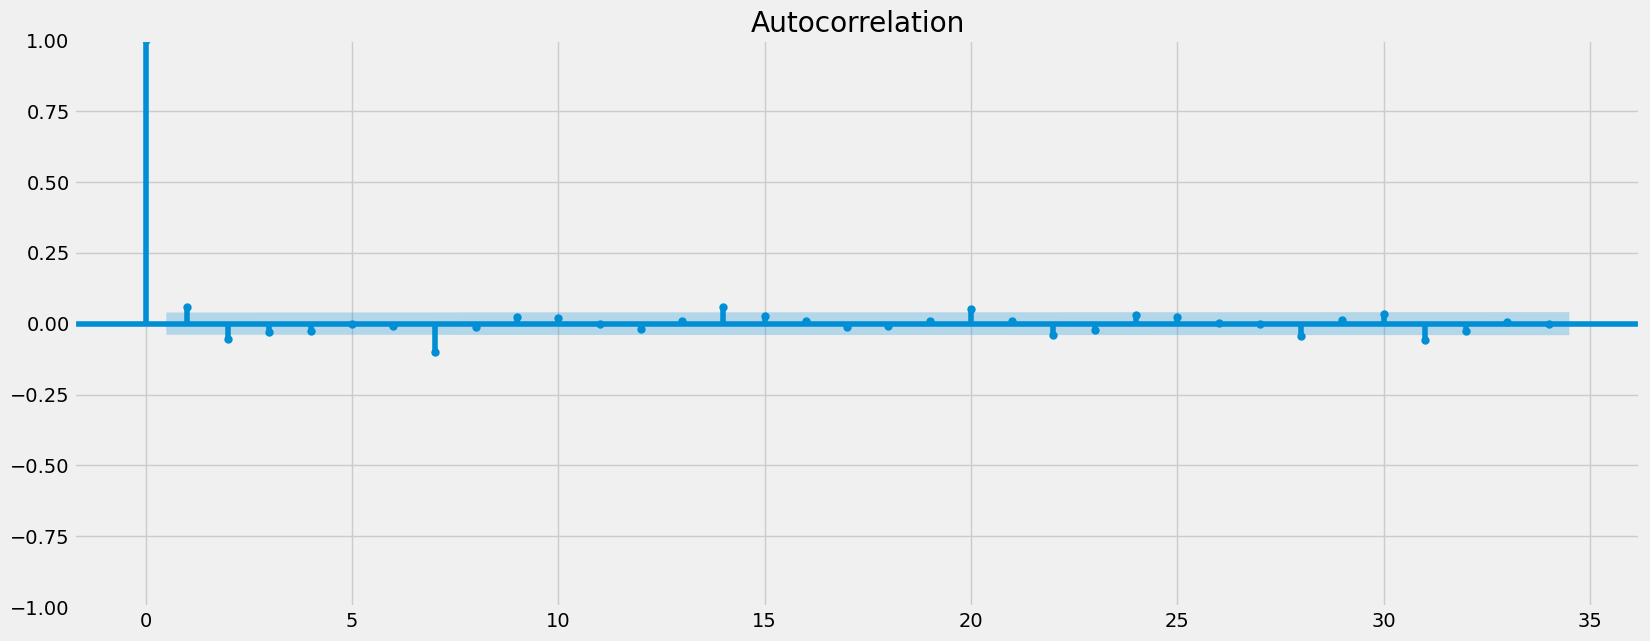

In [53]:
plot_acf(data_diff)
plt.show()

### Now test-statistic is at -21.724382 and Critical Value (10%) -2.567388, which is bigger than test-statistic. And p-value is at 0.0000 meaning we can reject the null hypothesis and, as a result, consider series stationary.

## Conclusion:

### While the autocorrelation plot has improved (there are fewer autocorrelated terms), it’s still not perfect. This means that, despite the Dickey-Fuller test saying that your data is stationary, that stationarity is weak